# Introduction

This demo functions allow users to remotely access and load a specific resolution level (pyramid series) from a large OME-TIFF<br>
image file—without downloading the entire file. It uses smart streaming tools to efficiently retrieve just the image data needed,<br>
making it ideal for working with massive microscopy datasets. The images are hosted on a remote server, and the demo provides a user <br>
interface to select the desired resolution level.<br>

The images can be associated with segmentation data, e.g., cells, which can be visualized alongside the image.<br>
We show how to display cells on the image, and then apply affine transformations to the cells<br>
to overlay them on the Xenium coordinates.<br>

## Import python libraries

In [1]:
import os
import tifffile
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import fsspec
import zarr
import xarray as xr
from kerchunk.tiff import tiff_to_zarr
import urllib.request
import zipfile

def downloadFromZenodo(targetDir, url, zip_file='dataset.zip'):
    
    """Download the dataset from Zenodo and extracts it to the specified directory."""

    if not os.path.isdir(targetDir):
        def reporthook(a, b, c):
            print(f"\rDownloading: {(a * b) // 1024**2} MB", end='')
        urllib.request.urlretrieve(url, zip_file, reporthook)
        print()
        os.makedirs(targetDir, exist_ok=True)
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(targetDir)
        os.remove(zip_file)
        print(f"Downloaded and extracted dataset into '{targetDir}'.")
    else:
        print(f"Directory '{targetDir}' already exists. Skipping download.")
    return

def read_ome_tiff_series(url: str, series_index: int = 0):

    """
    Reads a specific pyramid series from a remote OME-TIFF file using fsspec + kerchunk + zarr.

    Parameters:
        url (str): URL to the remote OME-TIFF file.
        series_index (int): Index of the pyramid level to read (0 = highest resolution).

    Returns:
        xarray.DataArray: The image data for the specified pyramid level.
    """

    # Generate kerchunk reference directly from URL
    ref = tiff_to_zarr(url)

    # Create a mapper from the reference
    fs = fsspec.filesystem("reference", fo=ref)
    mapper = fs.get_mapper("")

    # Open the dataset
    ds = xr.open_zarr(mapper, consolidated=False)

    # Access the requested series
    level_key = str(series_index)
    if level_key not in ds:
        raise ValueError(f"Series index {series_index} not found. Available keys: {list(ds.keys())}")

    return ds[level_key]

## Connect to remote storage and inspect the image structure

In [2]:
url = "https://assets.api.sennetconsortium.org/49dad6221c05a563a075b2bf564be2f1/ometiff-pyramids/lab_processed/images/Image_0017272.ome.tif?token="

imgFull = read_ome_tiff_series(url, series_index=0)
imgFull

<xarray.DataArray '0' (C: 3, Y: 78877, X: 72428)> Size: 69GB
dask.array<open_dataset-0, shape=(3, 78877, 72428), dtype=float32, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Dimensions without coordinates: C, Y, X

## Load a small region in full resolution

The entire image is large, about 12 GB. Downloading the entire image may take a while depending on the network connection.
In addition, the downloaded image will take significant space on the computer.

<br>
We load a small region, e.g., 2000 by 2000 pixels, that can be viewed right away.
The pixels values is only loaded by accession ".values" after slicing the Xarray.

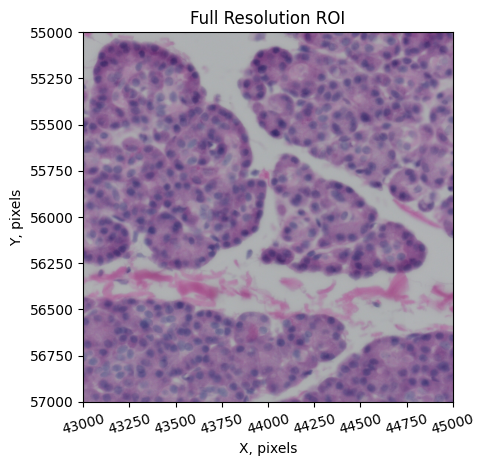

In [3]:
x1, y1 = 43000, 55000
dx, dy = 2000, 2000
x2, y2 = x1 + dx, y1 + dy
imgFullROI = imgFull[:, y1:y2, x1:x2].values.astype(np.uint8)
plt.imshow(np.moveaxis(imgFullROI, 0, -1), extent=(x1, x2, y2, y1))
plt.title("Full Resolution ROI")
ax = plt.gca()
ax.set_xlabel("X, pixels")
ax.set_ylabel("Y, pixels")
plt.xticks(rotation=15)
plt.show()

## StarDist nuclei segmentation

In [4]:
from stardist.models import StarDist2D
from csbdeep.utils import normalize

model = StarDist2D.from_pretrained('2D_versatile_he')

bioimageio_utils.py (2): pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


In [5]:
img_normalized = normalize(np.moveaxis(imgFullROI.copy(), 0, -1), 1, 99.8)

nuclei_mask, details = model.predict_instances(img_normalized)
nuclei_boundaries = details['coord']

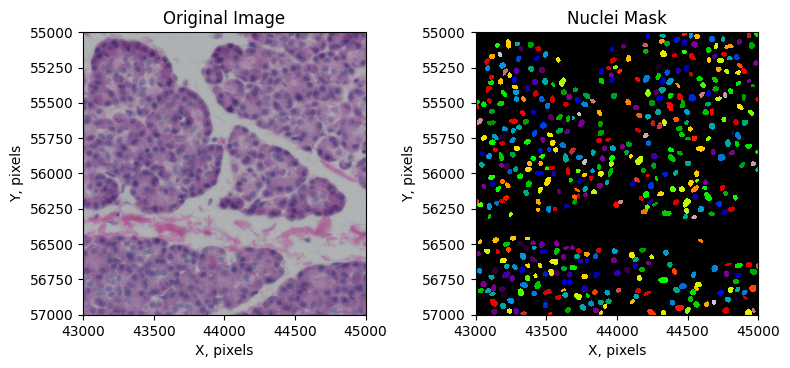

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(np.moveaxis(imgFullROI, 0, -1), cmap='gray', interpolation='none', extent=(x1, x2, y2, y1))
ax2.imshow(nuclei_mask, cmap='nipy_spectral', interpolation='none', extent=(x1, x2, y2, y1))
ax1.set_title("Original Image")
ax2.set_title("Nuclei Mask")
ax1.set_xlabel("X, pixels")
ax2.set_xlabel("X, pixels")
ax1.set_ylabel("Y, pixels")
ax2.set_ylabel("Y, pixels")
plt.tight_layout()

## Overlay nuclei boundaries on original image

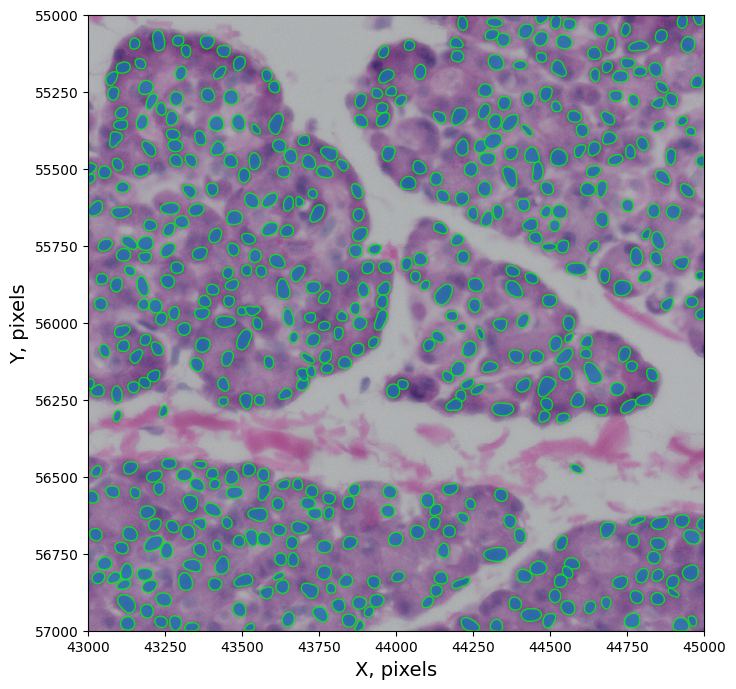

In [7]:
adjusted_nuclei_boundaries = np.moveaxis(nuclei_boundaries, -2, -1)[..., ::-1] + np.array([[x1, y1]])

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(np.moveaxis(imgFullROI, 0, -1), cmap='gray', interpolation='none', extent=(x1, x2, y2, y1))
ax.add_collection(PatchCollection([(Polygon(c, closed=True)) for c in adjusted_nuclei_boundaries], edgecolor='lime', facecolor=None, alpha=0.75))
ax.set_xlabel("X, pixels", fontsize=14)
ax.set_ylabel("Y, pixels", fontsize=14)
plt.show()

## Download a downsampled version of the image, from the same URL

In [8]:
# Connect to remote storage downsampled series, e.g. series 3
imgConnector = read_ome_tiff_series(url, series_index=3)
print(imgConnector.shape)

# Load the downsampled series by converting to numpy array
img = imgConnector.values.astype(np.uint8)

(3, 9859, 9053)


2954344204.py (6): invalid value encountered in cast


## Display the downsampled image and segmented nuclei

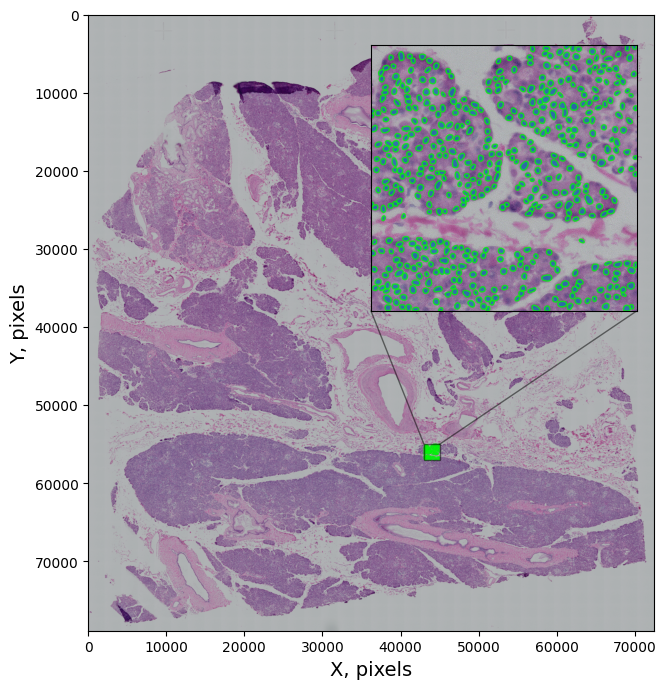

In [9]:
# Even the downsampled image may be too large to display in full resolution,
# so we will downsample it further for plots
f = 2  # Further downsampling factor
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(np.moveaxis(img[:, ::f, ::f], 0, -1), extent=(0, imgFull.shape[2], imgFull.shape[1], 0))
ax.set_xlabel('X, pixels', fontsize=14)
ax.set_ylabel('Y, pixels', fontsize=14)
ax.tick_params(axis='x', labelrotation=0)
ax.add_collection(PatchCollection([(Polygon(c, closed=True)) for c in adjusted_nuclei_boundaries], edgecolor='lime', alpha=0.75))

# Add inset with full resolution ROI from above
if True:
    axins = ax.inset_axes([0.5, 0.5, 0.47, 0.47], xlim=(x1, x2), ylim=(y2, y1))
    axins.set_xticks([])
    axins.set_yticks([])
    axins.imshow(np.moveaxis(imgFullROI, 0, -1), interpolation='none', extent=(x1, x2, y2, y1))
    axins.add_collection(PatchCollection([(Polygon(c, closed=True)) for c in adjusted_nuclei_boundaries], edgecolor='lime', facecolor=None, alpha=0.75))
    ax.indicate_inset_zoom(axins, edgecolor='k')

plt.show()

## Define the transformation to convert the H&E-derived cells coordinates to Xenium coordinates

In [10]:
# Use the pre-computed affine transformation matrix
# The mattrices can be found in the "extras" or "transformation" directory of each the repository whenever available.
M = np.array([[1.786119779961643740e-03,6.443031167854157415e-01],
            [-6.443483716831650554e-01,1.235765492824911086e-03]])
Tr = np.array([4.039155169888560408e+02, 4.698404373738830327e+04])
print(M)
print(Tr)

mpp_Xe = 0.2125

[[ 0.00178612  0.64430312]
 [-0.64434837  0.00123577]]
[  403.91551699 46984.04373739]


### Download demo Xenium dataset and load it into memory

In [11]:
dataPath = './'

In [12]:
dataSubPathXeniumSlim = "xenium-slim-JDC-WP-012-w"
url = "https://zenodo.org/api/records/15777586/files-archive"
downloadFromZenodo(os.path.join(dataPath, dataSubPathXeniumSlim), url)

Directory './xenium-slim-JDC-WP-012-w' already exists. Skipping download.


In [13]:
import pandas as pd

def load_xenium_dataset(id, path, N=None, suffix=None, f=1.):

    """Load a Xenium dataset from a specified Xenium bundle directory.

    Parameters
    ----------
    id : str
        Identifier for the sample (not used internally).
    path : str
        Path to the Xenium bundle directory. This directory should contain
        'cells.parquet' and 'cell_feature_matrix.h5' files.
    N : int, optional
        Number of cells to randomly sample. If None, use all cells.
    suffix : str, optional
        Suffix to append to cell indices.
    f : float, optional
        Scaling factor for spatial coordinates (default is 1.0).

    Returns
    -------
    adata : AnnData
        Data object with spatial coordinates in `adata.obsm['spatial']`.
    """

    obs = pd.read_parquet(path + '/cells.parquet', engine='auto', columns=None,
                          storage_options=None, use_nullable_dtypes=False).set_index('cell_id')
    adata = sc.read_10x_h5(path + '/cell_feature_matrix.h5')
    if not N is None:
        adata = adata[adata.obs.sample(N).index]
    adata.obs = obs.loc[adata.obs.index]
    if not suffix is None:
        adata.obs.index = adata.obs.index + suffix
    adata.obsm['spatial'] = (adata.obs[['x_centroid', 'y_centroid']]*f).astype(int).values

    return adata

id = 'JDC-WP-012-w'
ad = load_xenium_dataset(id, os.path.join(dataPath, dataSubPathXeniumSlim), suffix='.' + id)

3028520430.py (27): The argument 'use_nullable_dtypes' is deprecated and will be removed in a future version.


## Plot the Xenium cells and the H&E cells via affine transformation

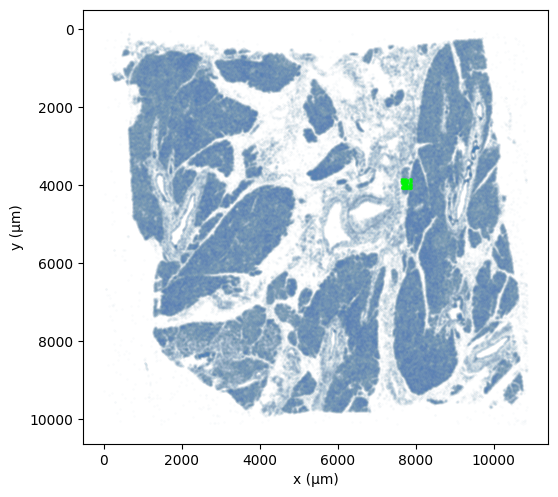

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(ad.obs['x_centroid'], ad.obs['y_centroid'], s=0.1, alpha=0.05, c='steelblue')

converted_nuclei_boundaries = adjusted_nuclei_boundaries.copy()
for i in range(len(adjusted_nuclei_boundaries)):
    xy = adjusted_nuclei_boundaries[i]
    converted_nuclei_boundaries[i] = (np.dot(xy, M.T) + Tr) * mpp_Xe

ax.add_collection(PatchCollection([(Polygon(c, closed=True)) for c in converted_nuclei_boundaries], edgecolor='lime', alpha=0.75))
ax.set_aspect('equal')
ax.invert_yaxis()
ax.set_xlabel('x (µm)')
ax.set_ylabel('y (µm)')
plt.show()

## Zoom in to a region of interest and plot Xenium cells with boundaries

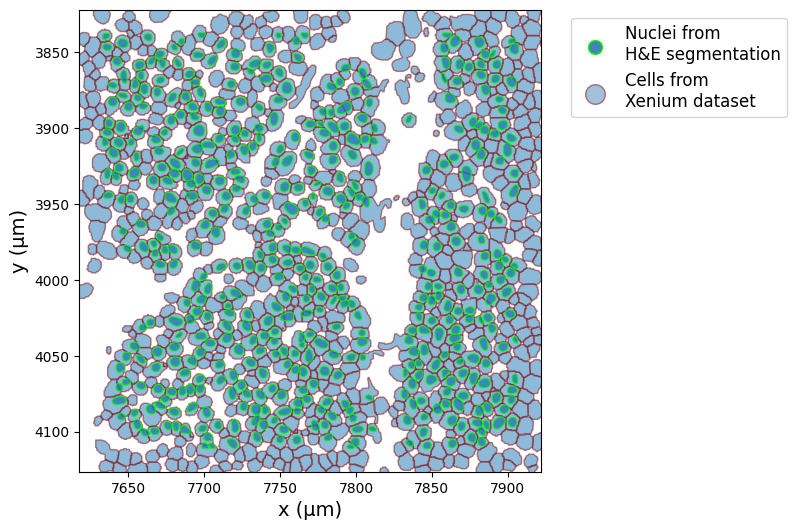

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

converted_nuclei_boundaries = adjusted_nuclei_boundaries.copy()
for i in range(len(adjusted_nuclei_boundaries)):
    xy = adjusted_nuclei_boundaries[i]
    converted_nuclei_boundaries[i] = (np.dot(xy, M.T) + Tr) * mpp_Xe

mins, maxs = converted_nuclei_boundaries.min(axis=(0, 1)), converted_nuclei_boundaries.max(axis=(0, 1))
b = 15
ax.set_xlim(mins[0]-b, maxs[0]+b)
ax.set_ylim(mins[1]-b, maxs[1]+b)

cond = (ad.obsm['spatial'][:, 0] > mins[0] - b) & (ad.obsm['spatial'][:, 0] < maxs[0] + b) & \
        (ad.obsm['spatial'][:, 1] > mins[1] - b) & (ad.obsm['spatial'][:, 1] < maxs[1] + b)
roi_cells = ad.obs.index[cond]
try:
    dfb
except:
    dfb = pd.read_parquet(os.path.join(dataPath, dataSubPathXeniumSlim, 'cell_boundaries.parquet')).set_index('cell_id')[['vertex_x', 'vertex_y']]
    dfb.index += '.' + id
xenium_cell_boundaries = dfb.loc[roi_cells.values].groupby('cell_id').agg(list).values

ax.add_collection(PatchCollection([(Polygon(np.vstack(c).T, closed=True)) for c in xenium_cell_boundaries], edgecolor='maroon', facecolor=None, alpha=0.5))
ax.add_collection(PatchCollection([(Polygon(c, closed=True)) for c in converted_nuclei_boundaries], edgecolor='lime', alpha=0.75))

plt.scatter(mins[0]-100, mins[1]-100, s=100, c='steelblue', marker='o', ec='lime', label='Nuclei from\nH&E segmentation')
plt.scatter(mins[0]-100, mins[1]-100, s=200, c='steelblue', marker='o', ec='maroon', alpha=0.5, label='Cells from\nXenium dataset')
plt.legend(loc='upper right', fontsize=12, bbox_to_anchor=(1.55, 1.0))

ax.invert_yaxis()
ax.set_aspect('equal')
ax.set_xlabel('x (µm)', fontsize=14)
ax.set_ylabel('y (µm)', fontsize=14)
plt.show()